<a href="https://colab.research.google.com/github/robertosgpontes/osem/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Formulação Geral do Problema

O problema apresentado pode ser formulado através de uma

\begin{equation}
	\max  \sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i} = \max \sum_{i=1}^{n}{C_{i}^1X_i}
\end{equation}
e
\begin{equation}
\min \sum_{i=1}^{n}{C_{i}^2X_i}
\end{equation}


Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


# Methodology

https://www.supplychaindataanalytics.com/multi-objective-linear-optimization-with-pulp-in-python/

https://pythonhealthcare.org/tag/pareto-front/



### Approach 1: Solution with Hierarchical Methodology

Maximizing for one objective, then adding it as a constraint and solving for the other objective

#### 1.1. First Step

\begin{equation}
S_1 = \max \sum_{i=1}^{n}{C_{i}^1X_i}
\end{equation}

Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}

#### 1.2. Second Step


\begin{equation}
\min \sum_{i=1}^{n}{C_{i}^2X_i}
\end{equation}
Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
\max \sum_{i=1}^{n}{C_{i}^1X_i} \geq S_1
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


## Approach 2: Solution with ...

\begin{equation}
	\max  \alpha\sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i} - (1-\alpha)\sum_{i=1}^{n}{C_iX_i}
\end{equation}

Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}

# General Definitions

## Language

In [16]:
% pip install pulp
!rm /content/utils.py
!wget https://raw.githubusercontent.com/robertosgpontes/osem/main/utils.py
%run /content/utils.py

--2021-08-21 19:35:08--  https://raw.githubusercontent.com/robertosgpontes/osem/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2110 (2.1K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.06K  --.-KB/s    in 0s      

2021-08-21 19:35:08 (31.3 MB/s) - ‘utils.py’ saved [2110/2110]



<Figure size 432x288 with 0 Axes>

In [17]:
# Python libraries used to solve the problem Linear Programing
import pulp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Problem Solution

In [18]:
NUM_ITER = 1000

# Solution

##Paper 1 (P1): Optimizing the Management of Soil Erosion

Nikkami, Davood & Elektorowicz, Maria & MEHUYS, GUY. (2002). Optimizing the Management of Soil Erosion. Water Quality Research Journal in Canada. 37. 10.2166/wqrj.2002.038. 

### Model Parameter

In [19]:
# Variáveis do modelo

C = np.array([[10.54394,  0.0469 ,  0.59679,  0.02194],
              [1.41, 4.99, 2.41, 6.24]])

A = np.array([  [1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [1, 0, 1, 0],
                [1, 1, 1, 1],
                [1, 0, 0, 0],
                [0, 1, 0, 0]])

b = np.array([[557],[1143],[1577],[1700],[10310],[160],[6990]])

### Solution


#### Approach 1

##### Step 1

In [20]:
linearProblem = pulp.LpProblem("First_Objective_Max",pulp.LpMaximize)

X = create_x_variables()

linearProblem += f(C[0], X)

linearProblem = load_model(linearProblem, A, X, b)

solution = linearProblem.solve()

In [21]:
print_solution(solution, linearProblem, X)


Status = Optimal
Value = 6958.9145499999995
x1 = 557.0
x2 = 8610.0
x3 = 1143.0
x4 = 0.0


In [22]:
f1_max = pulp.value(linearProblem.objective)

##### Step 2

In [23]:
linearProblem = pulp.LpProblem("Second_Objective_Min",pulp.LpMinimize)

X = create_x_variables()

linearProblem += f(C[1], X)

linearProblem = load_model(linearProblem, A, X, b)

linearProblem += f(C[0], X) >= f1_max

solution = linearProblem.solve()

In [24]:
print_solution(solution, linearProblem, X)


Status = Optimal
Value = 46503.9
x1 = 557.0
x2 = 8610.0
x3 = 1143.0
x4 = 0.0


#### Approach 2

In [25]:
CMinMax = MinMax(C)
CStandardization = Standardization(C)

In [26]:
alpha_lin = np.linspace(0, 1, NUM_ITER)

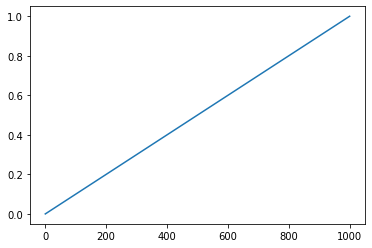

In [27]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_lin)

In [28]:
df_solution_lin = run_models(alpha_lin, C, A, b)

In [29]:
df_solution_lin

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,0.000000,Optimal,557.0,8610.0,1143.0,0.0,-46503.900000,6958.91455,-46503.9
1,1,0.001001,Optimal,557.0,8610.0,1143.0,0.0,-46450.383669,6958.91455,-46503.9
2,2,0.002002,Optimal,557.0,8610.0,1143.0,0.0,-46396.867338,6958.91455,-46503.9
3,3,0.003003,Optimal,557.0,8610.0,1143.0,0.0,-46343.351007,6958.91455,-46503.9
4,4,0.004004,Optimal,557.0,8610.0,1143.0,0.0,-46289.834676,6958.91455,-46503.9
...,...,...,...,...,...,...,...,...,...,...
995,995,0.995996,Optimal,557.0,8610.0,1143.0,0.0,6744.849226,6958.91455,-46503.9
996,996,0.996997,Optimal,557.0,8610.0,1143.0,0.0,6798.365557,6958.91455,-46503.9
997,997,0.997998,Optimal,557.0,8610.0,1143.0,0.0,6851.881888,6958.91455,-46503.9
998,998,0.998999,Optimal,557.0,8610.0,1143.0,0.0,6905.398219,6958.91455,-46503.9


In [30]:
alpha_sig_004 = sig(-0.004, NUM_ITER)

TypeError: ignored

In [ ]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_sig_004)

In [ ]:
df_solution_sig_004 = run_models(alpha_sig_004)

In [ ]:
df_solution_sig_004

In [ ]:
alpha_sig_06 = sig(-0.06, NUM_ITER)

In [ ]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_sig_06)

In [ ]:
df_solution_sig_06 = run_models(alpha_sig_06)

In [ ]:
df_solution_sig_06

In [ ]:
df_solution_sig_06.plot.scatter(x='f1', y='f2')

In [ ]:
df_solution_sig_06.plot.scatter(x='iter', y='obj_value')

##Paper 2 (P2): Land use optimization in watershed scale

Sadeghi, Seyed Hamidreza & Jalili, Khalil & Nikkami, Davood. (2009). Land use optimization in watershed scale. Land Use Policy. 26. 186-193. 10.1016/j.landusepol.2008.02.007. 

### Model Parameter

In [ ]:
# Variáveis do modelo

C = np.array([[21.452,  0.101 ,  4.56,  1.013],
              [8.77, 10.47, 12.57, 10.81]])

A = np.array([  [1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [1, 0, 1, 0],
                [1, 1, 1, 1],
                [1, 0, 0, 0],
                [0, 1, 0, 0]])

b = np.array([[2115],[237],[207],[2352],[13032],[561],[10550]])

### Solution


#### Approach 1

##### Step 1

In [ ]:
linearProblem = pulp.LpProblem("First_Objective_Max",pulp.LpMaximize)

X = create_x_variables()

linearProblem += f(C[0], X)

linearProblem = load_model(linearProblem, A, X, b)

solution = linearProblem.solve()

In [ ]:
print_solution(solution, linearProblem, X)

In [ ]:
f1_max = pulp.value(linearProblem.objective)

##### Step 2

In [ ]:
linearProblem = pulp.LpProblem("Second_Objective_Min",pulp.LpMinimize)

X = create_x_variables()

linearProblem += f(C[1], X)

linearProblem = load_model(linearProblem, A, X, b)

linearProblem += f(C[0], X) >= f1_max

solution = linearProblem.solve()

In [ ]:
print_solution(solution, linearProblem, X)

#### Approach 2

In [ ]:
CMinMax = MinMax(C)
CStandardization = Standardization(C)

In [ ]:
alpha_lin = np.linspace(0, 1, NUM_ITER)

In [ ]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_lin)

In [ ]:
df_solution_lin = run_models(alpha_lin, C, A, b)

In [ ]:
df_solution_lin

In [ ]:
alpha_sig_004 = sig(-0.004, NUM_ITER)

In [ ]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_sig_004)

In [ ]:
df_solution_sig_004 = run_models(alpha_sig_004)

In [ ]:
df_solution_sig_004

In [ ]:
alpha_sig_06 = sig(-0.06, NUM_ITER)

In [ ]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_sig_06)

In [ ]:
df_solution_sig_06 = run_models(alpha_sig_06)

In [ ]:
df_solution_sig_06

In [ ]:
df_solution_sig_06.plot.scatter(x='f1', y='f2')

In [ ]:
df_solution_sig_06.plot.scatter(x='iter', y='obj_value')